In [1]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

# SemTorch
from semtorch import get_segmentation_learner

from pathlib import Path
import random
import torch
torch.cuda.set_device(0)
import numpy as np
import cv2
import PIL
from PIL import Image, ImageOps

C:\Users\iisaragon\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\iisaragon\anaconda3\envs\torch\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [2]:
import sys
sys.path.insert(1, '../utils/')
from kfold import *
sys.path.insert(1, '../utils/')
from metrics import *

### We set a random seed for reproducibility

In [3]:
number_of_the_seed = 2020
random.seed(number_of_the_seed)
set_seed(number_of_the_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
path=Path('../dataset')
path_train=path/'train'
files=[path_train/f for f in os.listdir(path_train)]

### We show some images and its mask

<Axes: >

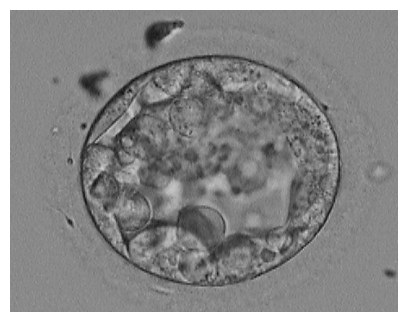

In [5]:
img = PILImage.create(files[1])
img.show(figsize=(5, 5))

In [8]:
get_y_fn = lambda x: Path(str(x).replace("train","GT_Mask"))

<Axes: >

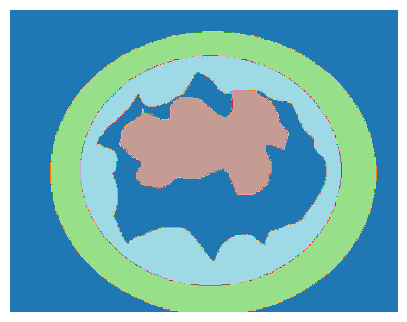

In [9]:
mask = PILMask.create(get_y_fn(files[1]))
mask.show(figsize=(5, 5), alpha=1)

### Setting some transformormations for data augmentation

In [11]:
from albumentations import (Compose,OneOf,ElasticTransform,GridDistortion, OpticalDistortion,HorizontalFlip,Rotate,Transpose,CLAHE,ShiftScaleRotate)
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    
    def __init__(self, aug): 
        self.aug = aug
        
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

In [ ]:
transforms=Compose([HorizontalFlip(p=0.5),Rotate(p=0.40,limit=10)],p=1)
transformPipeline=SegmentationAlbumentationsTransform(transforms)

### Transforming our  Ground Truth masks

In [14]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        # {'TE':255, 'ICM':150,'ZP':75}
        mask[mask==0]=0
        mask[mask==75]=1
        mask[mask==255]=2
        mask[mask==150]=3     
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

In [15]:
codes = np.array(['Background','ZP', 'TE', 'ICM'])

### Datablock

In [38]:
trainDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=[Resize((480,480)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats))

In [39]:
bs = 2
path_images=path_train
trainDLS = trainDB.dataloaders(path_images,bs=bs)

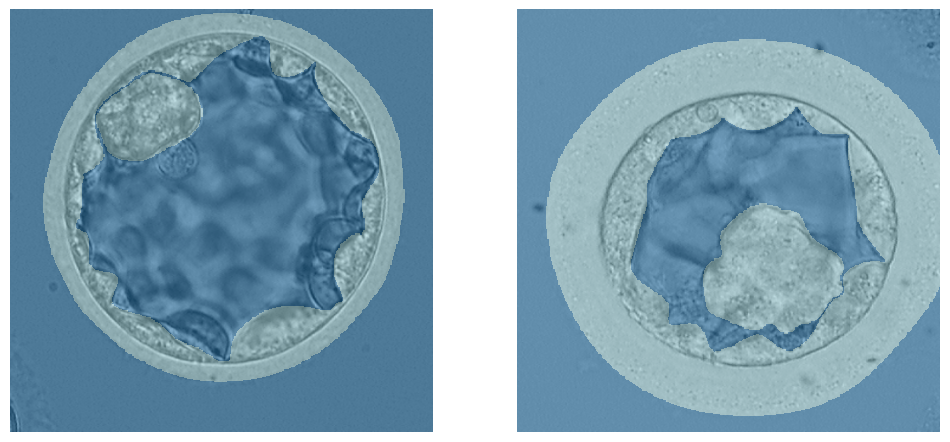

In [40]:
trainDLS.show_batch(vmin=0,vmax=1,figsize=(12, 9))

### Setting the callbacks and the optimizer

In [41]:
callbacks = [EarlyStoppingCallback(patience=3),SaveModelCallback(fname='model'),ReduceLROnPlateau(patience=3)]

In [42]:
opt = ranger

## Training

### Define the model

**model**: unet

**backbone**: resnet34

In [43]:
learn = unet_learner(trainDLS, resnet34, self_attention=True, act_cls=Mish, opt_func=opt,metrics=[DiceMulti()],cbs=callbacks)

C:\Users\iisaragon\anaconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\iisaragon\anaconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Find learning rate

SuggestedLRs(valley=0.00010964782268274575)

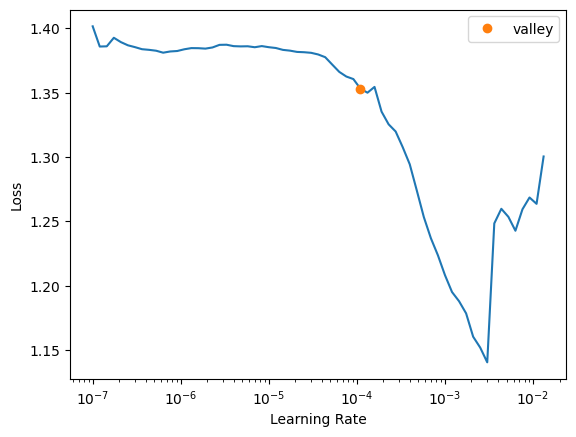

In [31]:
print(learn.recorder.metrics)
learn.lr_find(show_plot=True)

### Train for 20 epochs

In [32]:
learn.fit_one_cycle(20,1e-4)

epoch,train_loss,valid_loss,dice_multi,time
0,1.283113,1.252627,0.215438,00:27
1,0.859222,0.592899,0.674998,00:26
2,0.547603,0.393606,0.791156,00:26
3,0.404822,0.364972,0.796498,00:26
4,0.350575,0.345752,0.809747,00:26
5,0.318969,0.306350,0.829097,00:26
6,0.288289,0.269896,0.853383,00:26
7,0.264541,0.274723,0.847306,00:26
8,0.257093,0.289057,0.838080,00:26
9,0.233837,0.276617,0.841042,00:27


Better model found at epoch 0 with valid_loss value: 1.2526265382766724.
Better model found at epoch 1 with valid_loss value: 0.5928994417190552.
Better model found at epoch 2 with valid_loss value: 0.39360567927360535.
Better model found at epoch 3 with valid_loss value: 0.36497190594673157.
Better model found at epoch 4 with valid_loss value: 0.34575217962265015.
Better model found at epoch 5 with valid_loss value: 0.30634966492652893.
Better model found at epoch 6 with valid_loss value: 0.2698960602283478.
Epoch 9: reducing lr to 7.5108136016943974e-06
No improvement since epoch 6: early stopping


In [33]:
learn.fit_one_cycle(20,1e-4)

epoch,train_loss,valid_loss,dice_multi,time
0,0.224871,0.267152,0.853491,00:26
1,0.210717,0.259516,0.859743,00:26
2,0.223476,0.278269,0.840867,00:26
3,0.232881,0.283701,0.843845,00:26
4,0.221803,0.234678,0.876889,00:27
5,0.219667,0.251700,0.864209,00:26
6,0.203907,0.221497,0.883362,00:26
7,0.197216,0.225169,0.881396,00:26
8,0.185091,0.241960,0.870265,00:26
9,0.176545,0.229945,0.875989,00:27


Better model found at epoch 0 with valid_loss value: 0.2671518921852112.
Better model found at epoch 1 with valid_loss value: 0.2595158815383911.
Better model found at epoch 4 with valid_loss value: 0.23467808961868286.
Better model found at epoch 6 with valid_loss value: 0.2214968055486679.
Epoch 9: reducing lr to 7.5108136016943974e-06
No improvement since epoch 6: early stopping


### Unfreeze

In [34]:
learn.unfreeze()

SuggestedLRs(valley=3.0199516913853586e-05)

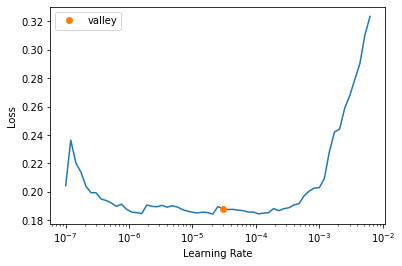

In [23]:
print(learn.recorder.metrics)
learn.lr_find(show_plot=True)

In [35]:
learn.fit_one_cycle(5,3e-5)

epoch,train_loss,valid_loss,dice_multi,time
0,0.172477,0.220113,0.881496,00:28
1,0.170892,0.245651,0.866108,00:28
2,0.162822,0.224188,0.880836,00:28
3,0.154111,0.220239,0.881784,00:28


Better model found at epoch 0 with valid_loss value: 0.22011332213878632.
Epoch 3: reducing lr to 5.074961120646109e-07
No improvement since epoch 0: early stopping


### Saving the model

In [37]:
aux=learn.model
aux=aux.cpu()

In [ ]:
import torchvision.transforms as transforms
img = PILImage.create(path_train+'Blast_PCRM_1201754 D5.BMP')
transformer=transforms.Compose([transforms.Resize((480,480)),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                                    [0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])])
img=transformer(img).unsqueeze(0)
img=img.cpu()

traced_cell=torch.jit.trace(aux, (img))
traced_cell.save("../models/models/unet.pth")

### Load the model

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model = torch.jit.load("../models/models/unet.pth")
model = model.cpu()

#### Define prediction function for predicting from a path

In [7]:
import torchvision.transforms as transforms
def transform_image(img):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    transformer=transforms.Compose([transforms.Resize((480,480)),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                                    [0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])])
    return transformer(img).unsqueeze(0).to(device)

In [8]:
def prediction(path):
    img = PIL.Image.open(path).convert('RGB')
    image = transforms.Resize((480,480))(img)
    tensor = transform_image(image)
    model.to(device)
    with torch.no_grad():
        outputs = model(tensor)

    outputs = torch.argmax(outputs,1)
    mask = np.array(outputs.cpu())
    mask[mask==1]=75
    mask[mask==2]=255
    mask[mask==3]=150
    mask=np.reshape(mask,(480,480))
    return np.array(transforms.Resize(img.shape)(Image.fromarray(mask.astype('uint8'))))

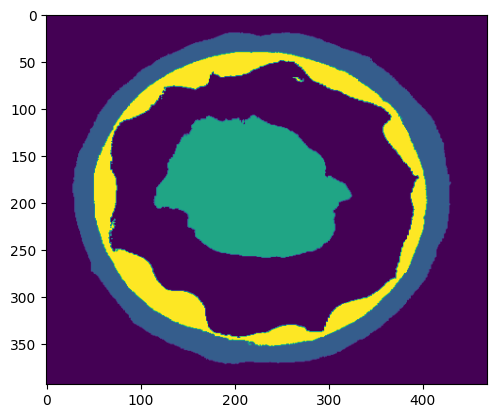

In [9]:
mask=prediction('../dataset/test/Blast_PCRM_R12-0316a.BMP')
img=cv2.imread('../dataset/test/Blast_PCRM_R12-0316a.BMP', cv2.IMREAD_GRAYSCALE)
plt.imshow(mask)

#### Saving the prediction

In [10]:
os.mkdir('unet')

In [25]:
path_save=Path('unet')
for f in files:
    mask=prediction(str(f))
    cv2.imwrite(str(path_save/f.name), mask)

### Evaluation

#### Define the metrics

In [11]:
def accuracy(target, prediction):
    true_detec = np.logical_not(np.logical_xor(target, prediction))
    return np.sum(true_detec)/np.sum(np.ones_like(target))

def precision(target, prediction):
    intersection = np.logical_and(target, prediction)
    return np.sum(intersection)/np.sum(prediction)

def recall(target, prediction):
    intersection = np.logical_and(target, prediction)
    return np.sum(intersection)/np.sum(target)

def jaccard(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    return np.sum(intersection) / np.sum(union)

def dice(target, prediction):
    intersection = np.logical_and(target, prediction)
    return 2*np.sum(intersection) / (np.sum(target) + np.sum(prediction))

def metrics(target, prediction):
    return {'accuracy': accuracy(target, prediction),
            'precision': precision(target, prediction),
            'recall': recall(target, prediction),
            'specificity': recall(1-target,1- prediction),
            'jaccard':jaccard(target, prediction),
            'dice': dice(target, prediction)}

def summary_metrics(y_test,predictions):
    a,p,r,s,j,d=0.,0.,0.,0.,0.,0.
    n=len(predictions)
    for i in range(n):
        preds= predictions[i]==255
        gt= y_test[i]==255
        metricas=metrics(gt,preds)
        a+=metricas['accuracy']
        p+=metricas['precision']
        r+=metricas['recall']
        s+=metricas['specificity']
        j+=metricas['jaccard']
        d+=metricas['dice']
    return {'accuracy': a/n,
            'precision': p/n,
            'recall': r/n,
            'specificity': s/n,
            'jaccard':j/n,
            'dice': d/n}

In [12]:
def get_mask(path,string,path_gt):
    file='GT_{}/'.format(string) +path.stem+' {}_Mask.bmp'.format(string)
    path_gt_file=str(path_gt/file)
    return cv2.imread(path_gt_file,cv2.IMREAD_GRAYSCALE)

In [13]:
path_test=path/'test'
files=[path_test/f for f in os.listdir(path_test)]
gtruth_zp=[get_mask(f,'ZP',path) for f in files]
gtruth_te=[get_mask(f,'TE',path) for f in files]
gtruth_icm=[get_mask(f,'ICM',path) for f in files]

In [14]:
preds=[prediction(f) for f in files]

In [15]:
preds_zp=[255*(p==75).astype('uint8') for p in preds]  
preds_te=[255*(p==255).astype('uint8') for p in preds]
preds_icm=[255*(p==150).astype('uint8') for p in preds]  

In [16]:
summary_metrics(gtruth_zp,preds_zp)

{'accuracy': 0.9617642605531715,
 'precision': 0.9026133508526085,
 'recall': 0.7948325553573357,
 'specificity': 0.9891126109730578,
 'jaccard': 0.7449351368779521,
 'dice': 0.8402757474683081}

In [17]:
summary_metrics(gtruth_te,preds_te)

{'accuracy': 0.962452688152654,
 'precision': 0.8608226743584829,
 'recall': 0.7908218533622012,
 'specificity': 0.9833802298722072,
 'jaccard': 0.693884140174354,
 'dice': 0.8081218525063342}

In [18]:
summary_metrics(gtruth_icm,preds_icm)

{'accuracy': 0.9792650155029857,
 'precision': 0.9091431825433086,
 'recall': 0.81399785662643,
 'specificity': 0.9920032838636429,
 'jaccard': 0.7425921143204012,
 'dice': 0.8312778157070294}

### INFERENCE

In [27]:
path_image='../img.png'
mask=prediction(path_image)

In [28]:
img=cv2.imread(path_image)

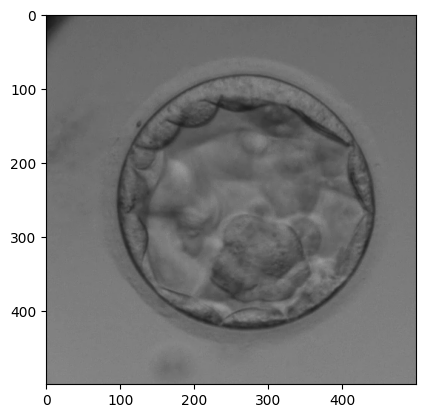

In [29]:
plt.imshow(img)

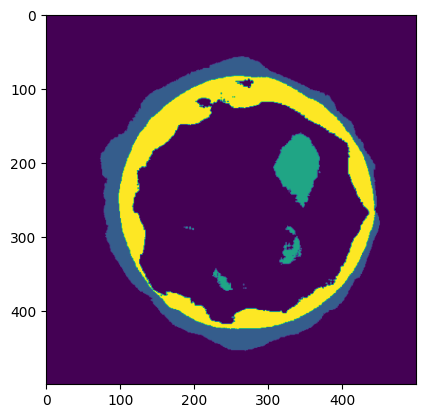

In [30]:
plt.imshow(mask)